<a href="https://colab.research.google.com/github/elvispletsch/bibliotecapandas/blob/main/Desafio_5_Prepare_seu_dataset_para_a_modelagem_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
135080
40
8905
5192


<ipython-input-11-145cd63720e6>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dados['TotalPrice'] = dados['Quantity'] * dados['UnitPrice']


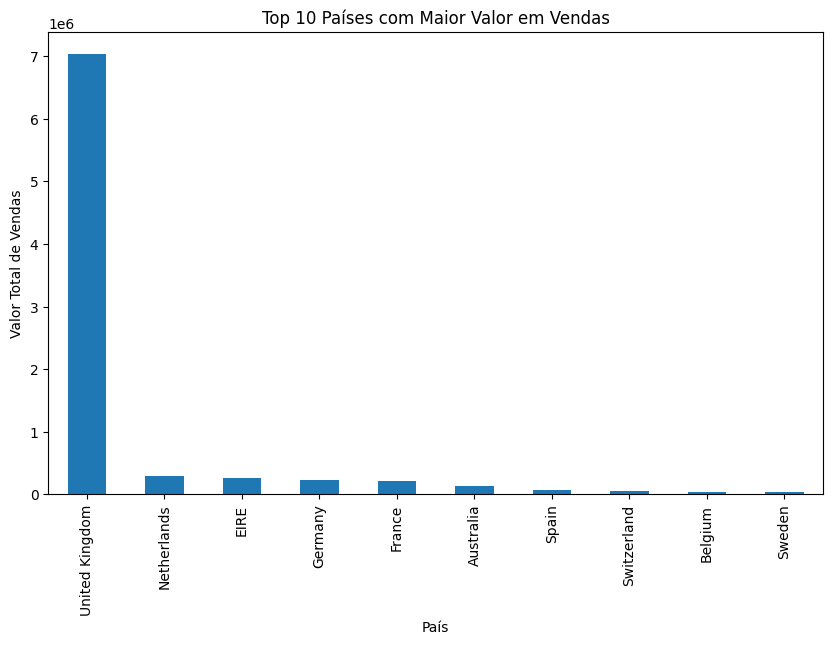

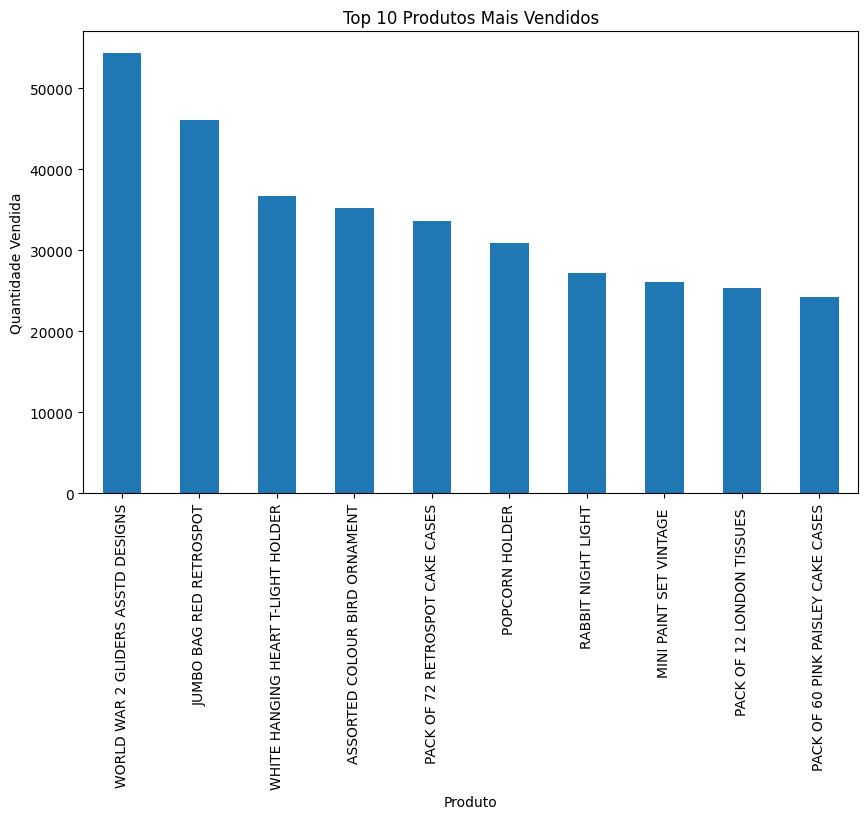

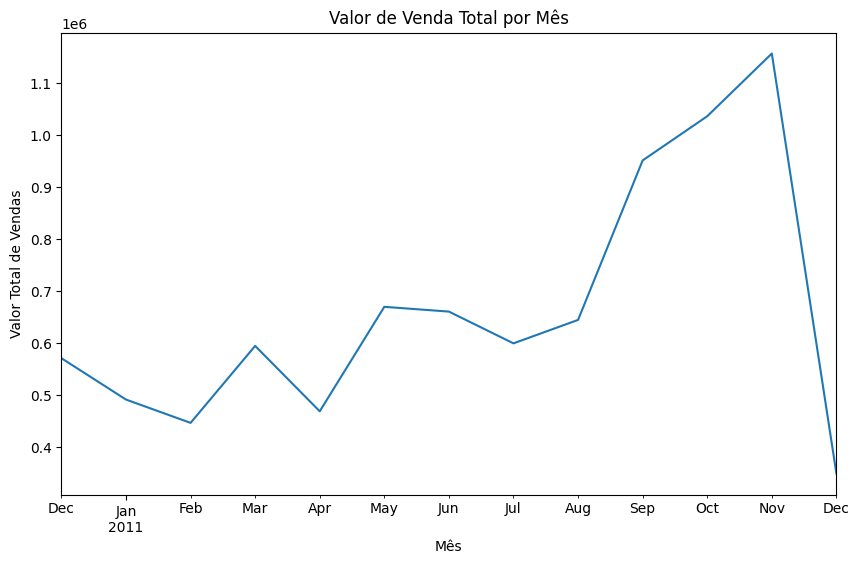

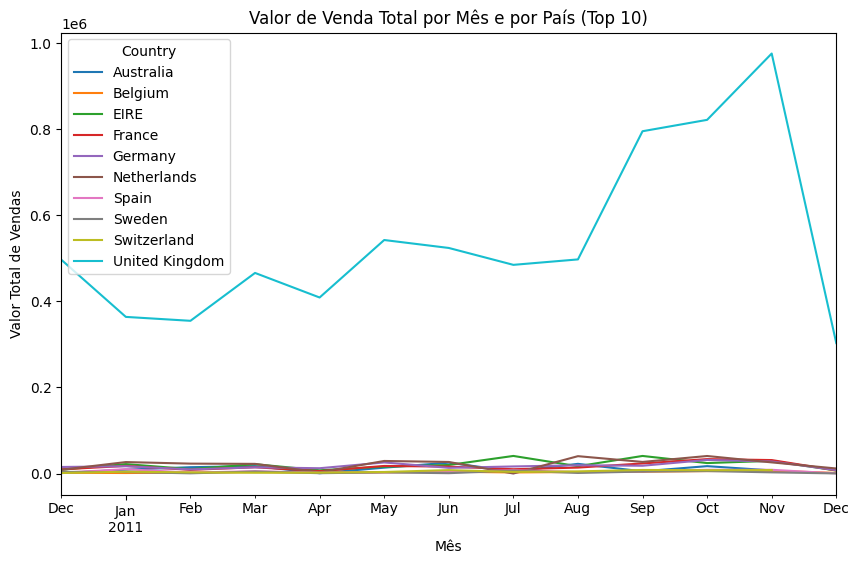

            Recência  Frequência  Ticket Médio
CustomerID                                    
12347              1           7    615.714286
12348             74           4    449.310000
12349             18           1   1757.550000
12350            309           1    334.400000
12352             35           8    313.255000
...              ...         ...           ...
18280            277           1    180.600000
18281            180           1     80.820000
18282              7           2     89.025000
18283              3          16    127.845625
18287             42           3    612.426667

[4337 rows x 3 columns]
Valores faltantes após a limpeza dos dados:
InvoiceNo                       0
StockCode                       0
Description                     0
Quantity                        0
InvoiceDate                     0
UnitPrice                       0
CustomerID                      0
TotalPrice                      0
ComprouProdutoX                 0
Country_Austri

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Etapa 01: Leia o dataset
dados = pd.read_csv("data (1).csv", encoding="unicode_escape")

# usando o describe para verificar a distribuição dos dados
print(dados.describe())

# verificando se há valores faltantes na identificação do cliente
print(dados['CustomerID'].isnull().sum())

# removendo observações com valores faltantes na identificação do cliente
dados.dropna(subset=['CustomerID'], inplace=True)

# verificando se há produtos com preços unitários iguais ou inferiores a 0
print((dados['UnitPrice'] <= 0).sum())

# removendo observações com preços unitários iguais ou inferiores a 0
dados = dados[dados['UnitPrice'] > 0]

# verificando se há produtos com quantidade igual ou inferior a 0
print((dados['Quantity'] <= 0).sum())

# removendo observações com quantidade igual ou inferior a 0
dados = dados[dados['Quantity'] > 0]

# verificando se existem linhas duplicadas
print(dados.duplicated().sum())

# removendo observações duplicadas
dados.drop_duplicates(inplace=True)

# corrigindo o tipo de dado do CustomerID
dados['CustomerID'] = dados['CustomerID'].astype(int)

# corrigindo o tipo de dado da InvoiceDate
dados['InvoiceDate'] = pd.to_datetime(dados['InvoiceDate'])

# Tratando outliers
dados = dados[(dados['Quantity'] <= 10000) & (dados['UnitPrice'] <= 5000)]

# criando uma coluna adicional para o total de cada compra
dados['TotalPrice'] = dados['Quantity'] * dados['UnitPrice']

# última data
ultima_data_compra = dados['InvoiceDate'].max()

# Plotando gráficos
# Top 10 países com maior valor em vendas
top_paises_vendas = dados.groupby('Country')['TotalPrice'].sum().nlargest(10)
top_paises_vendas.plot(kind='bar', figsize=(10, 6), title='Top 10 Países com Maior Valor em Vendas')
plt.xlabel('País')
plt.ylabel('Valor Total de Vendas')
plt.show()

# Top 10 produtos mais vendidos
top_produtos_vendidos = dados.groupby('Description')['Quantity'].sum().nlargest(10)
top_produtos_vendidos.plot(kind='bar', figsize=(10, 6), title='Top 10 Produtos Mais Vendidos')
plt.xlabel('Produto')
plt.ylabel('Quantidade Vendida')
plt.show()

# Valor de venda total por mês
vendas_por_mes = dados.resample('M', on='InvoiceDate')['TotalPrice'].sum()
vendas_por_mes.plot(kind='line', figsize=(10, 6), title='Valor de Venda Total por Mês')
plt.xlabel('Mês')
plt.ylabel('Valor Total de Vendas')
plt.show()

# Valor de venda total por mês e por país (considerando apenas os top 10)
top_paises = dados.groupby('Country')['TotalPrice'].sum().nlargest(10).index
vendas_por_mes_pais = dados[dados['Country'].isin(top_paises)].pivot_table(index=dados['InvoiceDate'].dt.to_period('M'), columns='Country', values='TotalPrice', aggfunc='sum')
vendas_por_mes_pais.plot(kind='line', figsize=(10, 6), title='Valor de Venda Total por Mês e por País (Top 10)')
plt.xlabel('Mês')
plt.ylabel('Valor Total de Vendas')
plt.show()

# Cálculo do RFM
agrupado_cliente_pedido = dados.groupby(['CustomerID', 'InvoiceNo']).agg({
    'InvoiceDate': lambda x: (ultima_data_compra - x.max()).days,
    'TotalPrice': 'sum',
    'Quantity': 'count'
})

# agregando novamente apenas por cliente
resumo_cliente = agrupado_cliente_pedido.groupby('CustomerID').agg({
    'InvoiceDate': 'min',  # Recência
    'Quantity': 'count',   # Frequência
    'TotalPrice': 'mean'   # Ticket Médio
})

# renomeando as colunas
resumo_cliente.columns = ['Recência', 'Frequência', 'Ticket Médio']

print(resumo_cliente)

# calculando o total de compras feitas por cada cliente:
total_compras_cliente = dados.groupby('CustomerID')['TotalPrice'].sum()

# calculando o total de produtos únicos comprados por cada cliente:
produtos_unicos_cliente = dados.groupby('CustomerID')['StockCode'].nunique()

#criando uma variável binária indicando se o cliente comprou um produto específico:
dados['ComprouProdutoX'] = (dados['Description'] == 'Produto X').astype(int)

#codificando variáveis categóricas, como o país:
dados = pd.get_dummies(dados, columns=['Country'], drop_first=True)

#salvando o dataset preparado para a modelagem de dados em um novo arquivo CSV:
dados.to_csv('dataset_preparado.csv', index=False)

#checks finais
print("Valores faltantes após a limpeza dos dados:")
print(dados.isnull().sum())

print("Número de observações após remover outliers:")
print(len(dados))

print("Tipos de dados após correção:")
print(dados.dtypes)

print("Número de duplicatas após remoção:")
print(dados.duplicated().sum())

print("Amostra dos dados com colunas adicionais:")
print(dados.head())
